# Libraries

In [ ]:
import sys
import time

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS

from scipy.ndimage import gaussian_filter1d
from scipy.special import softmax

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Set general plotting parameters
plt.rcParams.update({'font.size': 14, 'figure.figsize': (10, 6), 'axes.labelsize': 16, 'axes.titlesize': 18,
                     'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'figure.dpi': 200})
plt.rcParams['font.family'] = 'serif'

# Data

In [ ]:
# Load the original RC cube
rc_spectra_original = fits.getdata('/scratch/mk27/em8117/HISA/riegel_crutcher.fits')[0]
rc_spectra_original_flat = rc_spectra_original.reshape(rc_spectra_original.shape[0], -1).swapaxes(0, 1)
rc_spectra_original_scaled = rc_spectra_original_flat / 100 # Scale the data to be roughly between 0 and 1
rc_spectra_tensor = torch.tensor(rc_spectra_original_scaled, dtype=torch.float32)
# Create dummy labels
rc_labels_tensor = torch.zeros(rc_spectra_tensor.shape[0], dtype=torch.int64)

rc_original_dataset = torch.utils.data.TensorDataset(rc_spectra_tensor, rc_labels_tensor)
rc_original_dataloader = torch.utils.data.DataLoader(rc_original_dataset, batch_size=32, shuffle=False)

In [ ]:
# Get the WCS information for the R-C cloud data
rc_header_original = fits.getheader('/scratch/mk27/em8117/HISA/riegel_crutcher.fits')
rc_wcs = WCS(rc_header_original).celestial

In [ ]:
rc_header = fits.getheader('/scratch/mk27/em8117/HISA/riegel_crutcher.fits')
crval3_rc = rc_header['CRVAL3']
cdelt3_rc = rc_header['CDELT3']
naxis3_rc = rc_header['NAXIS3']
rc_vels = crval3_rc / 1000 + np.arange(naxis3_rc) * cdelt3_rc / 1000.0  # Convert to km/s

# Neural Network: Design HISA detector and training process

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, device=None, verbose=False):
        super().__init__()
        if device is None:
            if torch.backends.mps.is_available() and torch.backends.mps.is_built():
                device = 'mps'
            else:
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print('Using device:', device)
        self.device = torch.device(device)
        self.verbose = verbose
        self.default_weights_path = None  # to be set in subclasses if pretrained weights are available

    def preprocess_inputs(self, x):
        """ Default implementation. Override in subclasses if needed. """
        return x.to(self.device)

    def predict(self, test_loader, n_predictions=1):
        self.eval()
        all_predictions = []
        loop = tqdm(range(n_predictions), desc='Predicting', file=sys.stdout) if self.verbose else range(n_predictions)
        for _ in loop:
            predictions = []
            with torch.no_grad():
                for inputs, _ in test_loader:
                    inputs = self.preprocess_inputs(inputs)
                    outputs = self(inputs)
                    # Handle case of LSTM models returning a tuple (outputs, output history)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    predictions.append(outputs)
            all_predictions.append(torch.cat(predictions, dim=0))
        return torch.stack(all_predictions, dim=0)

    def evaluate(self, loader, criterion=nn.MSELoss()):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = self.preprocess_inputs(inputs)
                targets = targets.to(self.device)
                outputs = self(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = criterion(outputs, targets)
                total_loss += loss.item()
        return total_loss / len(loader)

    def load_weights(self, path=None):
        if path is None:
            if self.default_weights_path is None:
                raise ValueError("No path provided and no default weights path set.")
            path = self.default_weights_path
        print(f'Loading model from {path}')
        state_dict = torch.load(path, map_location=self.device)
        self.load_state_dict(state_dict)
        self.to(self.device)
        print('Model loaded successfully')


class HISAClassifier(BaseModel):
    def __init__(self, input_len, n_layers, n_kernels, kernel_size, **kwargs):
        super().__init__(**kwargs)

        print('Input length:', input_len, 'Kernel size:', kernel_size, 'Number of layers:', n_layers, 'Number of kernels per layer:', n_kernels)

        self.conv1 = nn.Conv1d(1, 16, kernel_size=kernel_size, padding=2)
        H1, W1 = self.get_output_size(1, input_len, [1, kernel_size], s=[1, 1], p=[0, 2], d=[1, 1])
        print('Input size:', input_len, 'Output size after first conv:', H1, W1)
        H2, W2 = self.get_output_size(H1, W1, [1, 2], s=[1, 2], p=[0, 0], d=[1, 1])
        print('Output size after first pooling:', H2, W2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=kernel_size, padding=2)
        H3, W3 = self.get_output_size(H2, W2, [1, kernel_size], s=[1, 1], p=[0, 2], d=[1, 1])
        print('Output size after second conv:', H3, W3)
        H4, W4 = self.get_output_size(H3, W3, [1, 2], s=[1, 2], p=[0, 0], d=[1, 1])
        print('Output size after second pooling:', H4, W4)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(32 * W4, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_output_size(self, Hin, Win, k, s=[1, 1], p=[0, 0], d=[1, 1]):
        Hout = int((Hin + 2 * p[0] - d[0] * (k[0] - 1) - 1) / s[0] + 1)
        Wout = int((Win + 2 * p[1] - d[1] * (k[1] - 1) - 1) / s[1] + 1)
        return Hout, Wout

    def preprocess_inputs(self, x):
        """ Preprocess inputs by unsqueezing to add channel dimension. """
        return x.unsqueeze(1).to(self.device) # Add channel dimension: (B, 1, L)

    def fit(self, train_loader, val_loader, checkpoint_path, n_epochs=100, lr=0.001, schedulerStep=15):
        self.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=schedulerStep)
        trainErrors = []
        valErrors = []
        epochTimes = []
        bestValLoss = float('inf')

        if checkpoint_path != None and checkpoint_path[-4:] != '.pth':
            raise ValueError("Checkpoint path must end with .pth")

        print('Training Model')
        print('Initial learning rate:', scheduler.get_last_lr())
        trainedEpochs = 0

        for epoch in range(n_epochs):
            self.train()
            startTime = time.time()
            runningLoss = 0.0
            loop = tqdm(train_loader, file=sys.stdout, desc=f'Epoch {epoch + 1}', unit='batch') if self.verbose else train_loader
            for inputs, targets in loop:
                inputs = self.preprocess_inputs(inputs)
                targets = targets.to(self.device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                runningLoss += loss.item()
                probabilities = F.log_softmax(outputs, dim=1)
                confidence, predictions = torch.max(probabilities, dim=1)
            trainLoss = runningLoss / len(train_loader)
            trainErrors.append(trainLoss)
            trainedEpochs += 1
            valLoss = self.evaluate(val_loader, criterion)
            valErrors.append(valLoss)

            lastLR = scheduler.get_last_lr()
            scheduler.step(valLoss)
            if lastLR != scheduler.get_last_lr():
                print(f'Learning rate changed to {scheduler.get_last_lr()}')

            print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {trainLoss:.4f}, Validation Loss: {valLoss:.4f}, took {time.time() - startTime:.2f}s')
            epochTimes.append(time.time() - startTime)

            if valLoss < bestValLoss:
                bestValLoss = valLoss
                if checkpoint_path is not None:
                    torch.save(self.state_dict(), checkpoint_path)

        return trainErrors, valErrors, trainedEpochs, epochTimes

    # Redefine the predict method to handle classification tasks

    def predict(self, test_loader):
        self.eval()
        all_predictions = []
        all_probabilities = []
        with torch.no_grad():
            for inputs, *_ in test_loader:
                inputs = self.preprocess_inputs(inputs)
                outputs = self(inputs)
                probabilities = torch.softmax(outputs, dim=1)
                _, predictions = torch.max(probabilities, dim=1)
                all_predictions.append(predictions)
                all_probabilities.append(probabilities)

        return torch.cat(all_predictions, dim=0), torch.cat(all_probabilities, dim=0)

# Load trained model

In [ ]:
# Initialise the model
rc_model = HISAClassifier(input_len=rc_spectra_original_flat.shape[1], n_layers=2, n_kernels=16, kernel_size=15)
# Load the weights
rc_model.load_weights('/home/120/em8117/HISA/rc_parameter_training_set.pth')

Using device: cuda
Input length: 800 Kernel size: 15 Number of layers: 2 Number of kernels per layer: 16
Input size: 800 Output size after first conv: 1 790
Output size after first pooling: 1 395
Output size after second conv: 1 385
Output size after second pooling: 1 192
Loading model from /home/120/em8117/HISA/rc_parameter_training_set.pth


/jobfs/155927763.gadi-pbs/ipykernel_3031608/3882902620.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=self.device)


Model loaded successfully


In [ ]:
rc_model

HISAClassifier(
  (conv1): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(2,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

# Make predictions on observed data: Riegel-Crutcher Cloud in the Milky Way

In [ ]:
# Get the predicted probabilities for the original R-C cloud spectra
rc_preds_original, rc_probs_original = rc_model.predict(rc_original_dataloader)

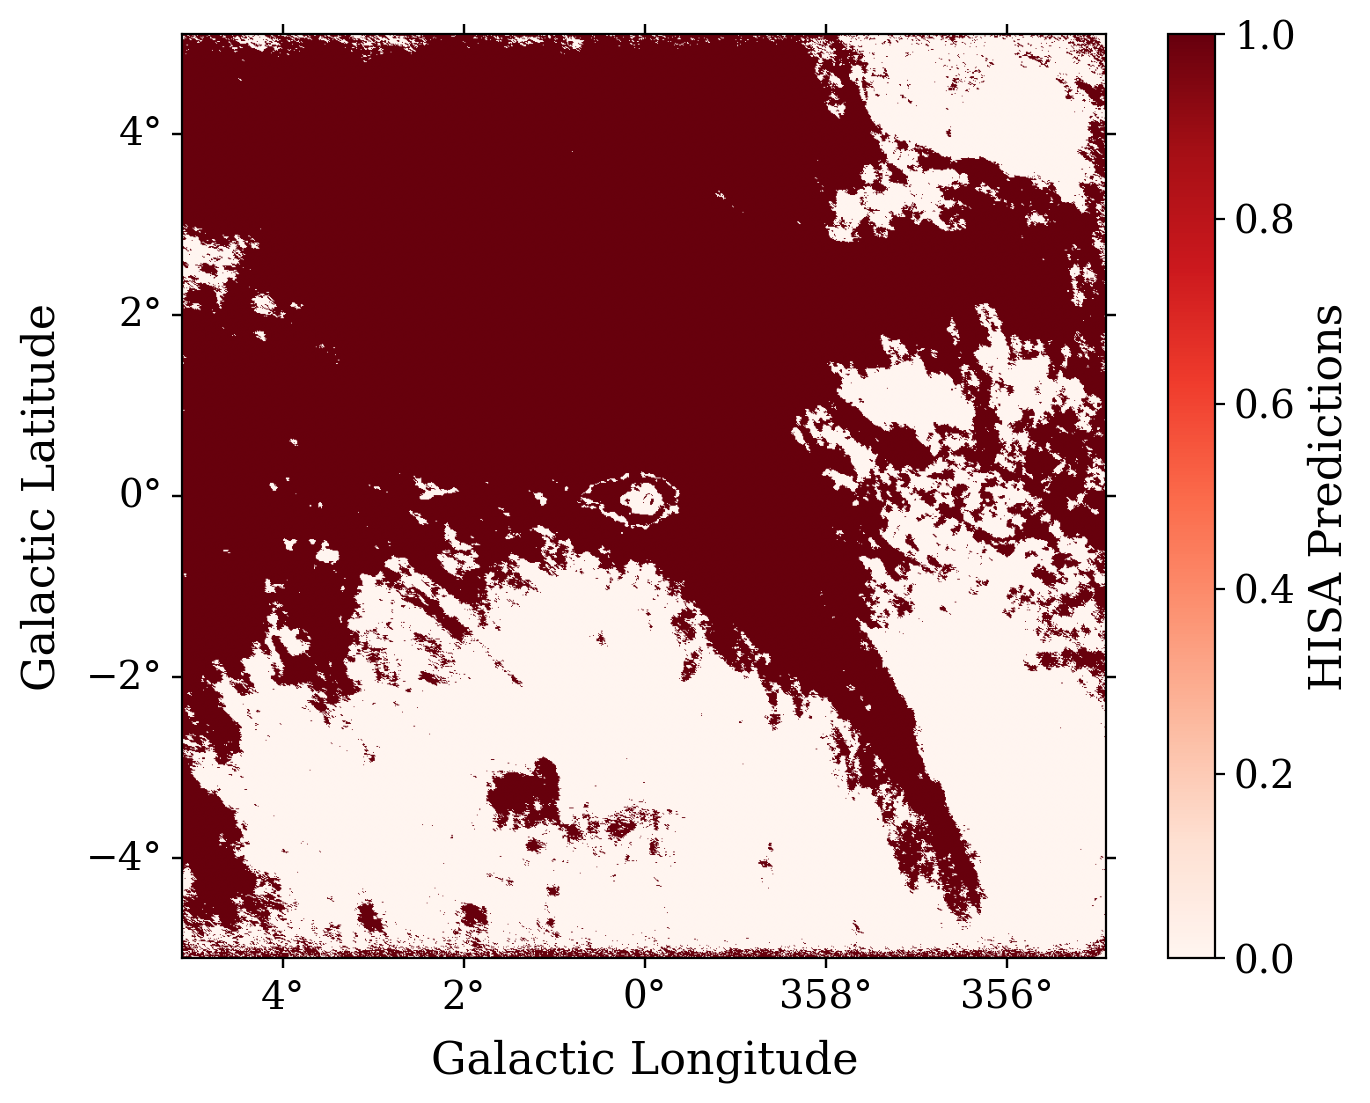

In [ ]:
# Plot the velocity map, masking to only pixels with predicted HISA
mask = rc_preds_original.cpu().numpy() == 1
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=rc_wcs)
im = ax.imshow(rc_preds_original.cpu().reshape(rc_spectra_original.shape[1], rc_spectra_original.shape[2]), origin='lower', cmap='Reds')
plt.colorbar(im, ax=ax, label='HISA Predictions')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
plt.show()

In [ ]:
# Get the saliency velocities for the original R-C cloud spectra by just taking the max of the activation maps and indexing the velocity axis

def get_activation_spectra(model, input_tensor):
    # Input must be a batch, ie 32 spectra
    input_tensor = input_tensor.to(model.device)
    input_tensor.requires_grad_()

    output = model(input_tensor.unsqueeze(1))  # output shape: [32, num_classes]

    # Select the top class for each spectrum
    output_idx = torch.argmax(output, dim=1)

    # Gather the max output per spectrum (returns [32] tensor)
    selected_outputs = output.gather(1, output_idx.unsqueeze(1)).squeeze()

    # Sum scalar outputs for a single backward call
    selected_outputs.sum().backward()

    # Saliency: absolute value of gradients
    saliency = input_tensor.grad.abs().cpu().numpy()

    return saliency

activation_vel_map_original = []

for data in rc_original_dataloader:
    inputs, _ = data
    batch_size = inputs.shape[0]
    activations = get_activation_spectra(rc_model, inputs)
    activation_map_vels = rc_vels[np.argmax(activations, axis=1)]
    activation_vel_map_original.extend(activation_map_vels)

activation_vel_map_original = np.array(activation_vel_map_original)
# Reshape to 2D map
activation_vel_map_original_2d = activation_vel_map_original.reshape(rc_spectra_original.shape[1], rc_spectra_original.shape[2])

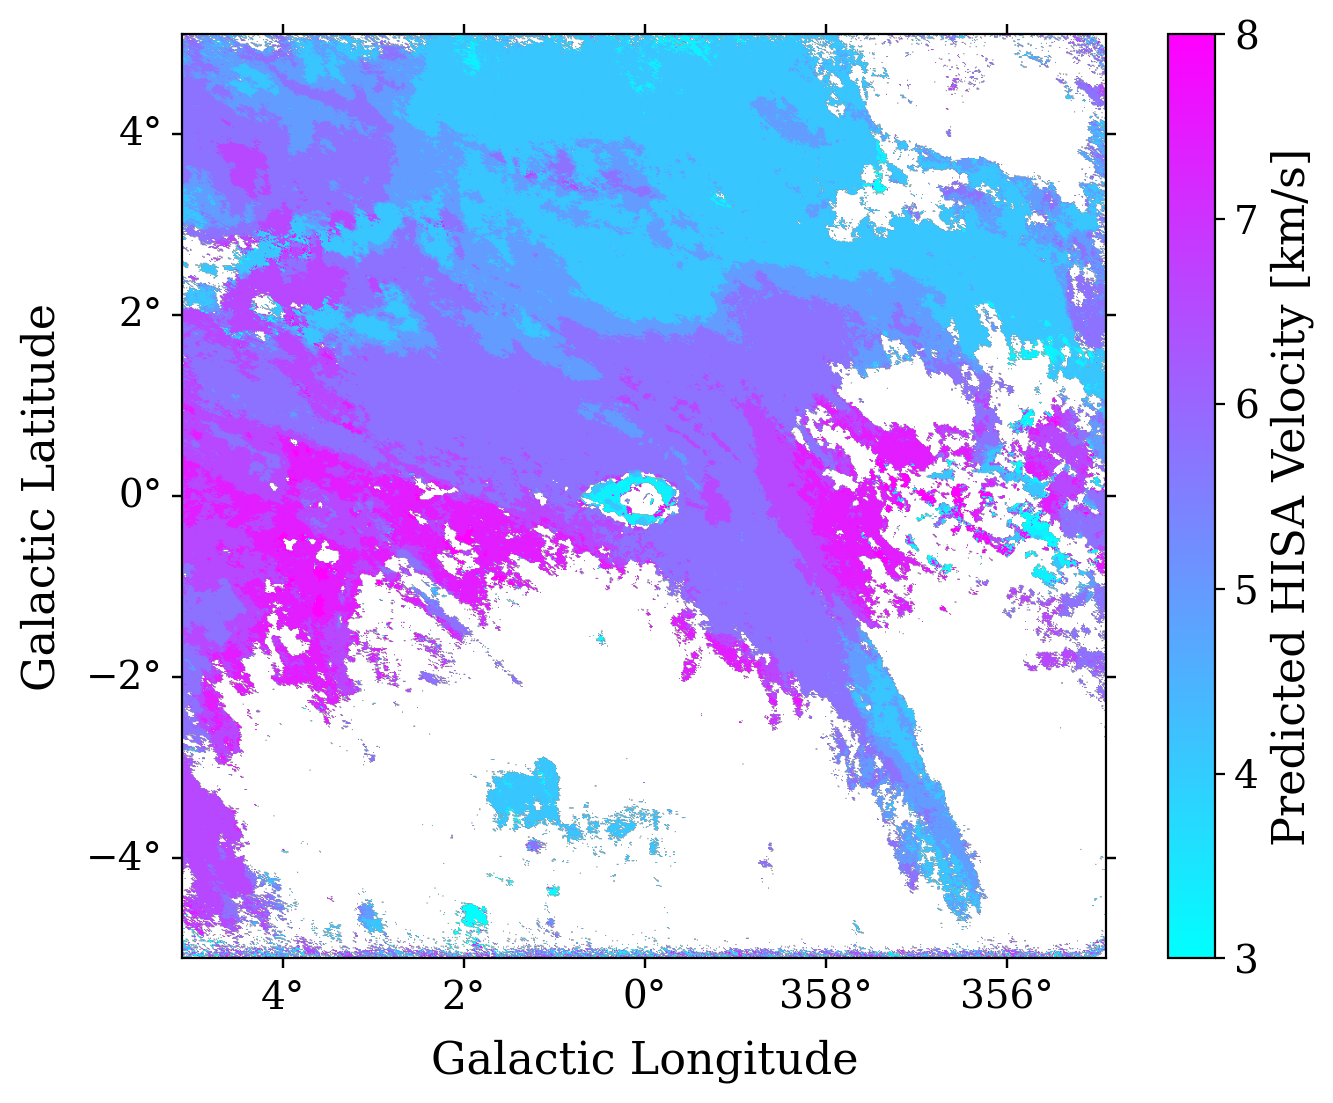

In [ ]:
# Plot the velocity map, masking to only pixels with predicted HISA
mask = rc_preds_original.cpu().numpy() == 1
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=rc_wcs)
im = ax.imshow(np.where(mask.reshape(rc_spectra_original.shape[1], rc_spectra_original.shape[2]), activation_vel_map_original_2d, np.nan), origin='lower', cmap='cool',vmin=3, vmax=8)
plt.colorbar(im, ax=ax, label='Predicted HISA Velocity [km/s]')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
plt.show()

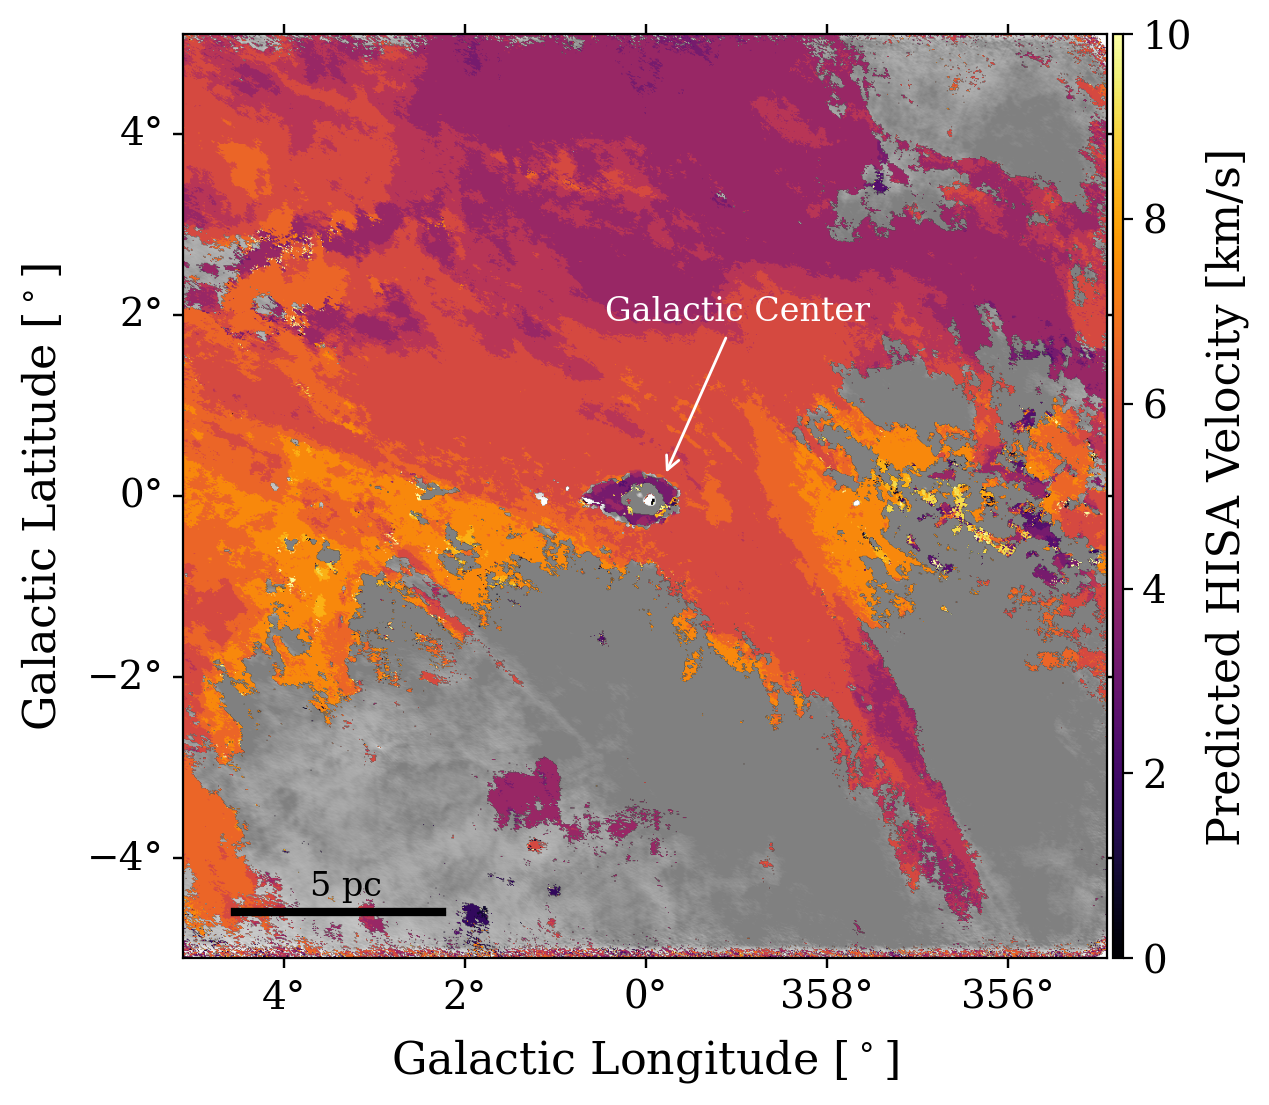

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=rc_wcs)

# Add the emission in the background at v closest to 5.5 km/s
v_bg = 5.5
v_bg_index = np.argmin(np.abs(rc_vels - v_bg))
rc_emission_bg = rc_spectra_original[v_bg_index, :, :]
ax.imshow(rc_emission_bg, origin='lower', cmap='Greys', alpha=0.5, vmin=0, vmax=100)

im = ax.imshow(np.where(mask.reshape(rc_spectra_original.shape[1], rc_spectra_original.shape[2]), activation_vel_map_original_2d, np.nan),
               origin='lower', cmap='inferno', vmin=0, vmax=10)

ax.set_xlabel(r'Galactic Longitude [$^\circ$]')
ax.set_ylabel(r'Galactic Latitude [$^\circ$]')

cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', fraction=0.008, pad=0.005, aspect=100)
cbar.ax.set_ylabel('Predicted HISA Velocity [km/s]', rotation=90, labelpad=5.)
# cbar.ax.tick_params(labelsize=20)

# Add a black bar that indicates the physical scale, given the distance to the R-C cloud of 125 pc
scale_length_pc = 5  # 1 pc scale bar
distance_pc = 125  # Distance to R-C cloud in pc
scale_length_deg = np.degrees(np.arctan(scale_length_pc / distance_pc))
scale_length_pix = scale_length_deg / rc_wcs.wcs.cdelt[0]
bar_x = 0.28 # Fractional position from left
bar_y = 0.05  # Fractional position from bottom
ax.plot([bar_x * rc_spectra_original.shape[2], (bar_x * rc_spectra_original.shape[2]) + scale_length_pix],
        [bar_y * rc_spectra_original.shape[1], bar_y * rc_spectra_original.shape[1]],
        color='black', linewidth=3)
ax.text(bar_x * rc_spectra_original.shape[2]-150, (bar_y * rc_spectra_original.shape[1])+10,
        f'{scale_length_pc} pc', color='black', fontsize=12, ha='left', va='bottom')


# Add an arrow and label that points to the Galactic Center the center of the image
ax.annotate('Galactic Center', xy=(0.52, 0.52), xytext=(0.6, 0.7),
            arrowprops=dict(facecolor='white', arrowstyle='->', edgecolor='white'),
            fontsize=12, color='white', ha='center', va='center',
            xycoords='axes fraction', textcoords='axes fraction')


plt.show()

# Activation spectra: identify HISA velocity

In [ ]:
# Make activation spectra for the spectrum at pixel coordinates (x=261, y=485) in the R-C cloud map.

# Get 32 spectra that includes the target spectrum
x_target = 261
y_target = 485
target_index = y_target * rc_spectra_original.shape[2] + x_target
start_index = max(0, target_index - 16)
end_index = min(rc_spectra_original_flat.shape[0], start_index + 32)
start_index = end_index - 32  # Ensure we have exactly 32 spectra

rc_spectra_batch = rc_spectra_tensor[start_index:end_index]

activation_spectra = get_activation_spectra(rc_model, rc_spectra_batch)
smoothed_activation_spectra = gaussian_filter1d(activation_spectra, sigma=2, axis=1)
pdf_activations = softmax(smoothed_activation_spectra , axis=1)

# Calculate the velocities by taking the weighted average of the velocity axis with the PDF as weights
activation_velocity_spectrum = np.sum(pdf_activations * rc_vels, axis=1)

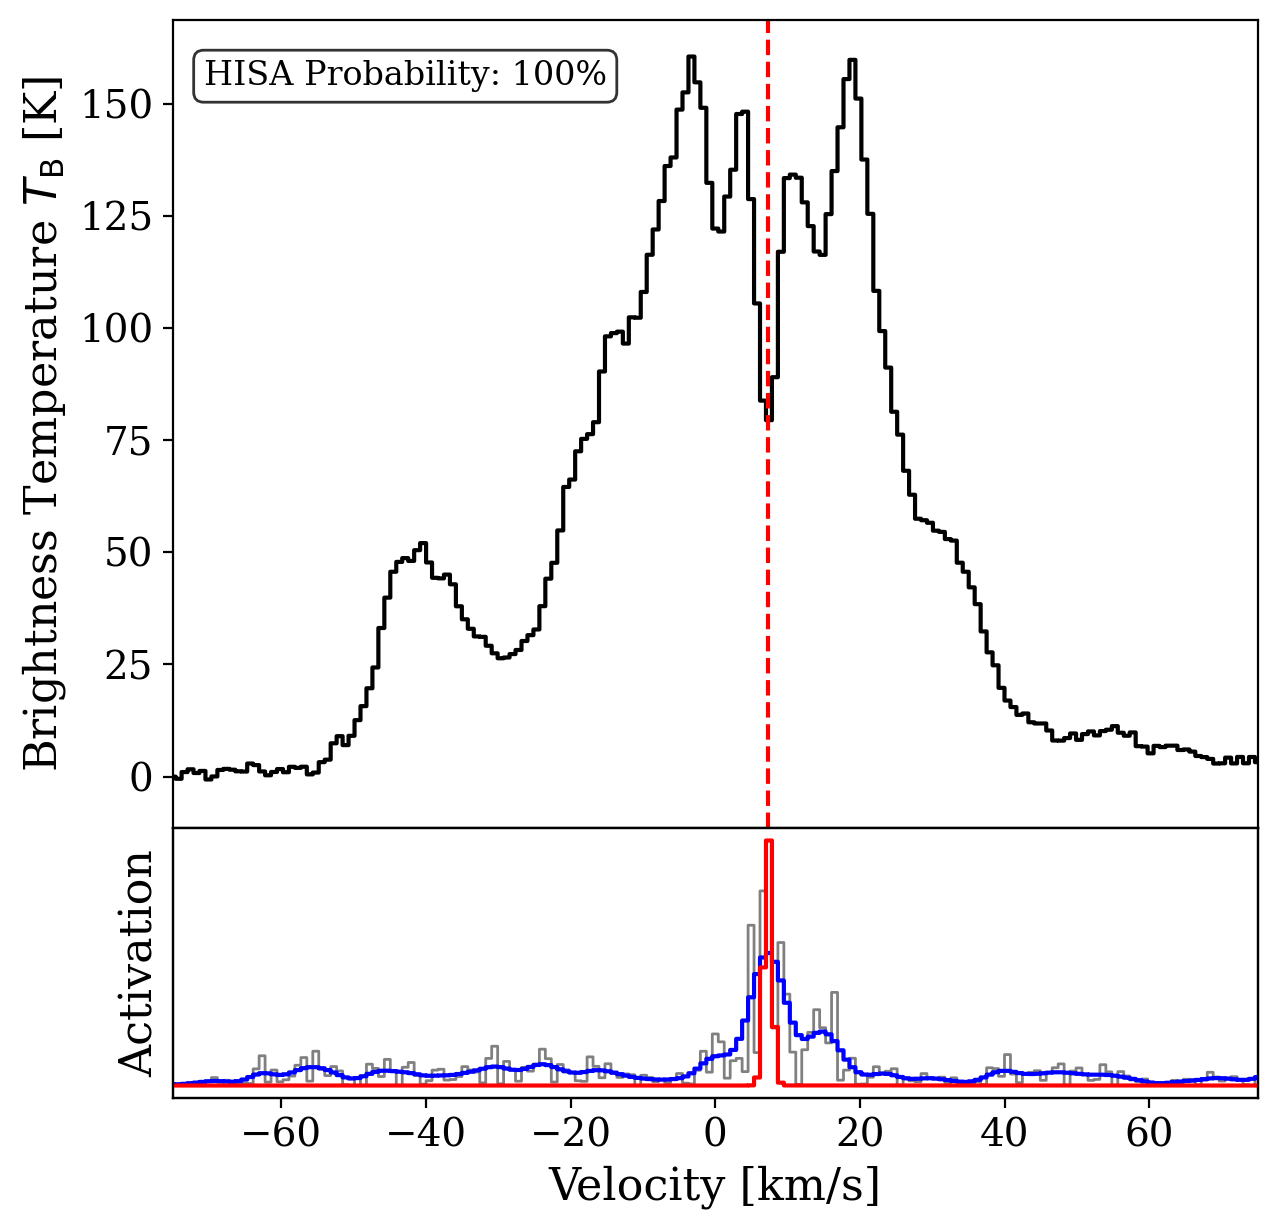

In [ ]:
idx = target_index - start_index  # Index of the target spectrum in the batch

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.0}, figsize=(7, 7))
# Add a twin axis to the second plot for the PDF activations
axs = axs.flatten()
axs = axs.tolist()
axs.append(axs[1].twinx())

ax = axs[0]
ax.step(rc_vels, rc_spectra_batch[idx].cpu().numpy() * 100.0, where='mid', color='black')
ax.set_ylabel(r'Brightness Temperature $T_\mathrm{B}$ [K]')
ax.axvline(activation_velocity_spectrum[idx], color='red', linestyle='--', label='Predicted HISA Velocity')
ax.set_xlim(-75, 75)  # Truncate x-axis to -50 to 50 km/s
# Add text to the first axis in the style of a legend that gives the prediction probability
prob = rc_probs_original[target_index, 1].item()
ax.text(0.4, 0.95, f'HISA Probability: {prob * 100:.0f}%', transform=ax.transAxes, ha='right', va='top', fontsize=12, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax = axs[1]
ax.step(rc_vels, activation_spectra[idx], where='mid', color='grey', lw=1)
ax.step(rc_vels, smoothed_activation_spectra [idx], where='mid', color='blue', label='Smoothed Activation')
# Turn off ticks for this axis
ax.set_yticks([])
ax.set_ylabel('Activation')
ax.set_xlabel('Velocity [km/s]')
ax = axs[2]
ax.step(rc_vels, pdf_activations[idx], where='mid', color='red', label='Activation PDF')
ax.set_xlabel('Velocity [km/s]')
# Turn off ticks for this axis
ax.set_yticks([])
plt.show()